In [1]:
!pip install transformers

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
!nvidia-smi

Sun Dec  8 09:06:21 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090      WDDM  |   00000000:01:00.0  On |                  Off |
|  0%   51C    P0             56W /  500W |    4147MiB /  24564MiB |      9%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [113]:
#@title import packages

import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import KMeans

import torch.nn as nn

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize, Resize, Compose, ToPILImage
torch.cuda.is_available()


True

In [114]:
torch.cuda.set_device(0)

In [115]:
#@title Plotting functions

import argparse
import torch
import matplotlib.pyplot as plt
import torchvision.transforms
from torch import nn
from torchvision import transforms
import torch.nn.modules.utils as nn_utils
import math
#import timm
import types
from pathlib import Path
from typing import Union, List, Tuple
from PIL import Image
from matplotlib.colors import ListedColormap

def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    r"""Rescale and displays an image represented as a img.
    The function scales the img :attr:`im` to the [0 ,1] range.
    The img is assumed to have shape :math:`3\times H\times W` (RGB)
    :math:`1\times H\times W` (grayscale).
    Args:
        img (:class:`torch.Tensor` or :class:`PIL.Image`): image.
        quiet (bool, optional): if False, do not display image.
            Default: ``False``.
        lim (list, optional): maximum and minimum intensity value for
            rescaling. Default: ``None``.
        interpolation (str, optional): The interpolation mode to use with
            :func:`matplotlib.pyplot.imshow` (e.g. ``'lanczos'`` or
            ``'nearest'``). Default: ``'lanczos'``.
    Returns:
        :class:`torch.Tensor`: Rescaled image img.
    """
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img)
    handle = None
    with torch.no_grad():
        if not lim:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            bitmap = img.expand(3,
                                *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
    return bitmap

def draw_correspondences(points1: List[Tuple[float, float]], points2: List[Tuple[float, float]],
                         image1: Image.Image, image2: Image.Image) -> Tuple[plt.Figure, plt.Figure]:
    """
    draw point correspondences on images.
    :param points1: a list of (y, x) coordinates of image1, corresponding to points2.
    :param points2: a list of (y, x) coordinates of image2, corresponding to points1.
    :param image1: a PIL image.
    :param image2: a PIL image.
    :return: two figures of images with marked points.
    """
    assert len(points1) == len(points2), f"points lengths are incompatible: {len(points1)} != {len(points2)}."
    num_points = len(points1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.axis('off')
    ax2.axis('off')
    #ax1.imshow(image1)
    #ax2.imshow(image2)
    ax1.imshow(imsc(image1))
    ax2.imshow(imsc(image2))

    if not points1:
      return fig

    if num_points > 15:
        cmap = plt.get_cmap('tab10')
    else:
        cmap = ListedColormap(["red", "yellow", "blue", "lime", "magenta", "indigo", "orange", "cyan", "darkgreen",
                               "maroon", "black", "white", "chocolate", "gray", "blueviolet"])
    colors = np.array([cmap(x) for x in range(num_points)])
    radius1, radius2 = 8, 1
    for point1, point2, color in zip(points1, points2, colors):
        y1, x1 = point1
        circ1_1 = plt.Circle((x1, y1), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ1_2 = plt.Circle((x1, y1), radius2, facecolor=color, edgecolor='white')
        ax1.add_patch(circ1_1)
        ax1.add_patch(circ1_2)
        y2, x2 = point2
        circ2_1 = plt.Circle((x2, y2), radius1, facecolor=color, edgecolor='white', alpha=0.5)
        circ2_2 = plt.Circle((x2, y2), radius2, facecolor=color, edgecolor='white')
        ax2.add_patch(circ2_1)
        ax2.add_patch(circ2_2)
    return fig

In [116]:
#@title load model and initialize descriptor
from transformers import CLIPVisionModel, CLIPTextModel, CLIPProcessor
from transformers import AutoProcessor, CLIPModel

# 加载processor和视觉模型
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14").to('cuda')

# 初始化关键点描述器
#descriptor = KeypointDescriptor(model, processor)
#descriptor.prepare_part_prompts()

In [117]:
#@title create dataset


from transformers import AutoProcessor, CLIPModel, CLIPProcessor


class CUB(Dataset):
    def __init__(self, base_path, train=True):
        self.base_path = base_path
        self.labels = pd.read_csv(''.join([base_path, 'image_class_labels.txt']),
                                header=None, sep=" ", names=["id", "label"])
        self.train_test_split = pd.read_csv(''.join([base_path, 'train_test_split.txt']),
                                          header=None, sep=" ", names=["id", "is_train"])
        self.filenames = pd.read_csv(''.join([base_path, 'images.txt']),
                                   header=None, sep=" ")

        # 使用全局定义的processor
        self.processor = processor  # 使用上面定义的processor

        if train:
            mask = self.train_test_split.is_train.values == 1
        else:
            mask = self.train_test_split.is_train.values == 0

        self.filenames = self.filenames.iloc[mask]
        self.labels = self.labels[mask]

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):
        y = self.labels.iloc[index, 1] - 1
        file_name = self.filenames.iloc[index, 1]

        x = Image.open(''.join([self.base_path, 'images/', file_name])).convert('RGB')
        x = self.processor(images=x, return_tensors="pt")

        return x['pixel_values'].squeeze(), y

[np.int64(28), np.int64(28), np.int64(30)]


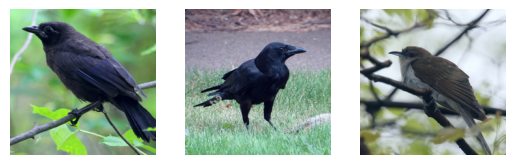

In [118]:
#@title dataset and dataloader and load samples

import random

base_path = 'CUB_200_2011/' # You need to change this.

train_dataset = CUB(base_path)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
#file_names, x, y = next(iter(train_loader))

random.seed(30)
inputs, labels = [], []
data_indices = []
#data_indices = random.sample(range(train_dataset.__len__()), 10)
# Here is where we pick the images to analyse. It is smart to pick one image from the same class and one from a different class.
# That generally gives more interesting results. The data is ordered, so class 1 starts from indices (0-30), class 2 from (30-60)
# and so on.

data_indices.append(856)
data_indices.append(858)
data_indices.append(924)


for counter, data_idx in enumerate(data_indices):

  x, y = train_dataset.__getitem__(data_idx)

  #if counter == 0: x = query_transforms(x)

  inputs.append(x)
  labels.append(y)

print(labels)

plt.figure(1)
plt.subplot(131)
plt.imshow(imsc(inputs[0]))
plt.axis('off')
plt.subplot(132)
plt.imshow(imsc(inputs[1]))
plt.axis('off')
plt.subplot(133)
plt.imshow(imsc(inputs[2]))
plt.axis('off')
plt.show()


In [119]:
#@title load model

from transformers import CLIPVisionModel, CLIPTextModel, CLIPProcessor
from transformers import AutoProcessor, CLIPModel

# You can use the CLIPTextModel to process the text data once you get that far.
# see https://huggingface.co/docs/transformers/model_doc/clip#transformers.TFCLIPTextModel
# for more information.

# 确保所有组件使用相同的模型版本
MODEL_NAME = "openai/clip-vit-large-patch14"

# 加载processors和模型
processor = CLIPProcessor.from_pretrained(MODEL_NAME)
vision_model = CLIPVisionModel.from_pretrained(MODEL_NAME).to('cuda')
text_model = CLIPTextModel.from_pretrained(MODEL_NAME).to('cuda')


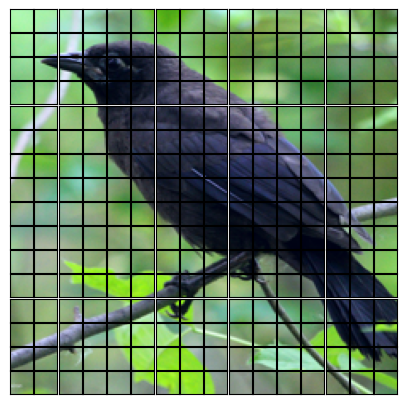

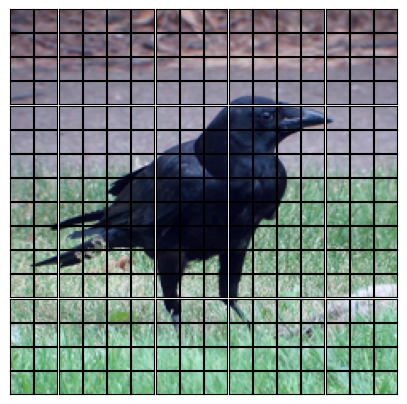

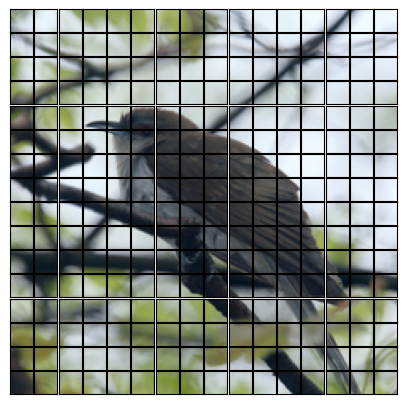

In [120]:
#@title plot patches


for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    img = img.permute(1, 2, 0)

    H, W, C = img.shape

    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    outputs = model(dummy_input)

    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = model.config.patch_size

    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(5, 5))

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)



In [121]:
#@title create patch embeddings

device='cuda'

embedings = []

with torch.no_grad():

    for counter, input_i in enumerate(inputs):

        input_i = input_i.to(device).unsqueeze(0)

        outputs = model(input_i, output_attentions=True)

        embedings.append(outputs.last_hidden_state[0, 1:, :].numpy(force=True))



In [122]:
#@title STEP 1: find best buddies

nearest_neighbor_query, distances_query = pairwise_distances_argmin_min(embedings[0], np.concatenate(embedings[1:]), axis=1, metric='cosine')
nearest_neighbor_prototypes, distances_prototype = pairwise_distances_argmin_min(embedings[0], np.concatenate(embedings[1:]), axis=0, metric='cosine')

best_buddies = nearest_neighbor_prototypes[nearest_neighbor_query] == np.arange(NUMBER_OF_PATCHES)

best_buddies_query_indices = np.where(best_buddies == True)[0]
best_buddies_prototypes_indices = nearest_neighbor_query[best_buddies]


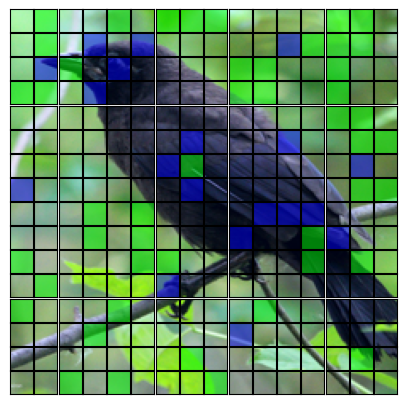

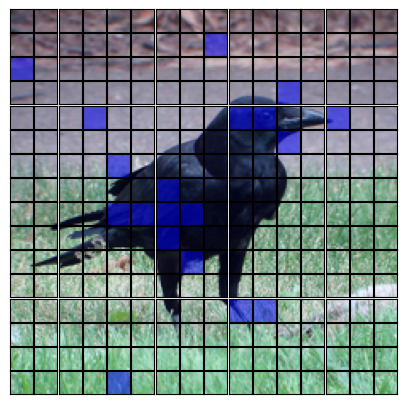

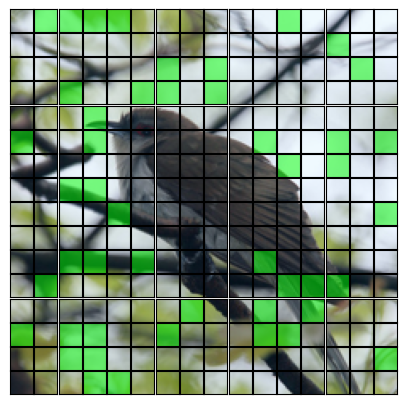

In [123]:
#@title plot patches with best buddies


for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    img = img.permute(1, 2, 0)

    H, W, C = img.shape

    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    outputs = model(dummy_input)

    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = model.config.patch_size

    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(5, 5))

    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

            if counter == 0:
                if n_rows*row_idx+col_idx in best_buddies_query_indices:
                  if best_buddies_prototypes_indices[best_buddy_counter] > NUMBER_OF_PATCHES:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                  else:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                  best_buddy_counter += 1

            if counter == 1:
                if n_rows*row_idx+col_idx in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

            if counter == 2:
                if (n_rows*row_idx+col_idx+NUMBER_OF_PATCHES) in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)




In [124]:
#@title STEP 2: find foreground and remove best buddies beloning to background

from sklearn.decomposition import PCA

pca = PCA(n_components=10)
# The following variable is important for the thresholding. You either set it to 0 or 1.
# In the more complete code this happens automatically as you will see later.
pca_component_to_threshold = 1
pca_features = pca.fit_transform(np.concatenate(embedings))

threshold = np.mean(pca_features[:, pca_component_to_threshold])
foreground_mask = pca_features[:, pca_component_to_threshold] > threshold+0.5*np.std(pca_features[:, pca_component_to_threshold])
foreground_mask = np.array(foreground_mask).reshape(-1, NUMBER_OF_PATCHES)

prototypes_foreground_new_coordinates = nearest_neighbor_prototypes[foreground_mask[1:].flatten()]
prototypes_foreground_mask_new_coordinates = np.zeros(NUMBER_OF_PATCHES, dtype=bool)
prototypes_foreground_mask_new_coordinates[prototypes_foreground_new_coordinates] = True

print(sum(best_buddies))

best_buddies = np.bitwise_and(best_buddies, foreground_mask[0])
best_buddies = np.bitwise_and(best_buddies, prototypes_foreground_mask_new_coordinates)

print(sum(best_buddies))

best_buddies_query_indices = np.where(best_buddies == True)[0]
best_buddies_prototypes_indices = nearest_neighbor_query[best_buddies]


66
13


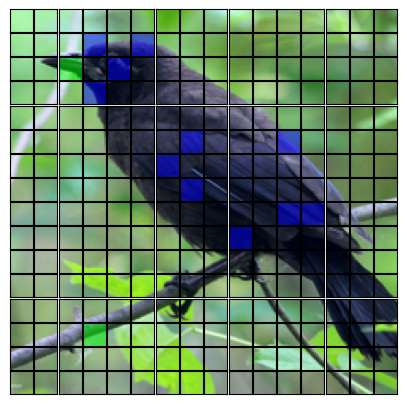

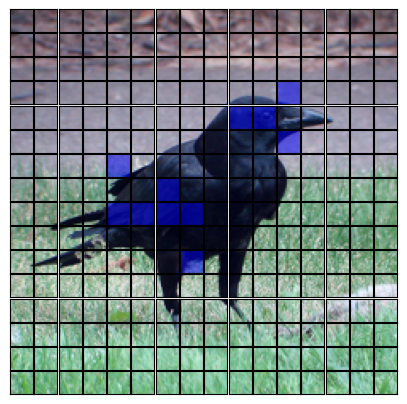

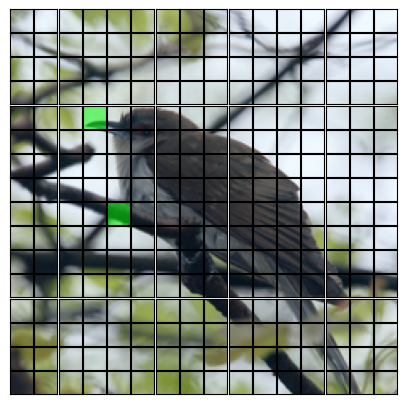

In [125]:
#@title plot patches with best buddies and background masked out


for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    img = img.permute(1, 2, 0)

    H, W, C = img.shape

    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    outputs = model(dummy_input)

    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = model.config.patch_size

    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(5, 5))

    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

            if counter == 0:
                if n_rows*row_idx+col_idx in best_buddies_query_indices:
                  if best_buddies_prototypes_indices[best_buddy_counter] > NUMBER_OF_PATCHES:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                  else:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                  best_buddy_counter += 1

            if counter == 1:
                if n_rows*row_idx+col_idx in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

            if counter == 2:
                if (n_rows*row_idx+col_idx+NUMBER_OF_PATCHES) in best_buddies_prototypes_indices:
                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    best_buddy_counter += 1

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)




In [126]:
#@title STEP 3: cluster best buddies


NUMBER_OF_PAIRS = 13 # This determines the number of clusters

bb_query = embedings[0][best_buddies, :]
bb_prototypes = np.concatenate(embedings[1:])[nearest_neighbor_query[best_buddies], :]

bb_combined_patches = np.concatenate((bb_query, bb_prototypes), axis=1)
bb_combined_patches = bb_combined_patches / np.linalg.norm(bb_combined_patches, axis=1, keepdims=True)

kmeans = KMeans(n_clusters=NUMBER_OF_PAIRS, random_state=0, n_init=10).fit(bb_combined_patches)
indices_to_show = np.argmin(kmeans.transform(bb_combined_patches), axis=0)

indices_to_show = np.nonzero(best_buddies)[0][indices_to_show]
query_indices_to_show = np.arange(NUMBER_OF_PATCHES)[indices_to_show]
prototype_indices_to_show = nearest_neighbor_query[indices_to_show]


print(query_indices_to_show)
print(prototype_indices_to_show)


[102  51 211 139  21 153  36  34  19  91 119  87 140]
[118  91 388 134  73 167  74 323  59 100 135 133 132]


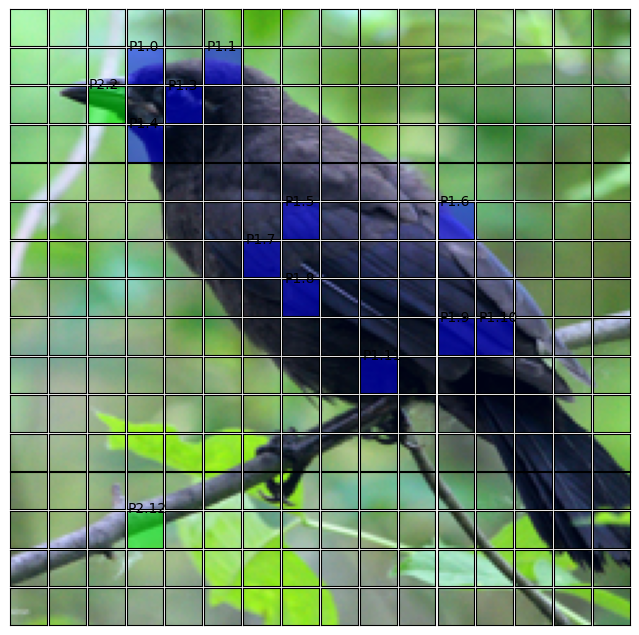

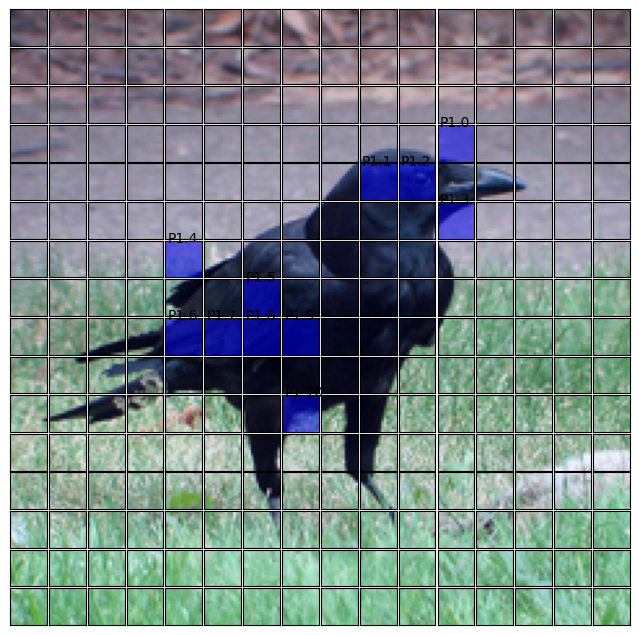

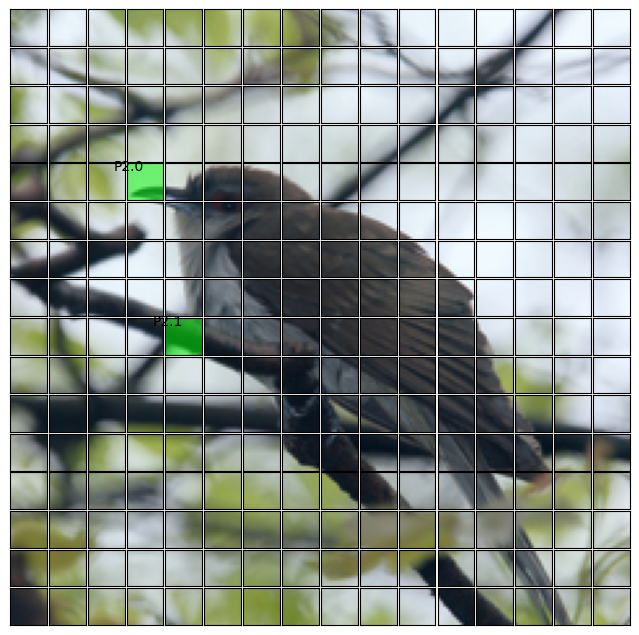

In [127]:
#@title plot query and prototypes with keypoints

for counter, img in enumerate(inputs):

    #img = inputs[0].permute(1, 2, 0)
    img = img.permute(1, 2, 0)

    H, W, C = img.shape

    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    outputs = model(dummy_input)

    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = model.config.patch_size

    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]

    #
    # Into patches
    # [n_rows, n_cols, patch_width, patch_width, C]
    #
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    #
    #Plot
    #
    f, axs = plt.subplots(n_rows, n_cols, figsize=(8, 8))

    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):

            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))

            if counter == 0:
                if n_rows*row_idx+col_idx in query_indices_to_show:
                    if best_buddies_prototypes_indices[best_buddy_counter] > NUMBER_OF_PATCHES:
                        color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                        color_shading[:,:,1] = 255
                        axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                        axs[row_idx, col_idx].text(0.0, 0.0, f"P2.{best_buddy_counter}")
                    else:
                        color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                        color_shading[:,:,2] = 255
                        axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)
                        axs[row_idx, col_idx].text(0.4, 0.5, f"P1.{best_buddy_counter}")

                    best_buddy_counter += 1

            if counter == 1:
                if n_rows*row_idx+col_idx in prototype_indices_to_show:

                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,2] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    axs[row_idx, col_idx].text(0.3, 0.0, f"P1.{best_buddy_counter}")
                    best_buddy_counter += 1

            if counter == 2:
                if (n_rows*row_idx+col_idx+NUMBER_OF_PATCHES) in prototype_indices_to_show:

                    color_shading = torch.zeros_like(patches[row_idx, col_idx, ...], dtype=torch.uint8)
                    color_shading[:,:,1] = 255
                    axs[row_idx, col_idx].imshow(color_shading, alpha=0.5)

                    axs[row_idx, col_idx].text(0.5, 0.5, f"P2.{best_buddy_counter}", horizontalalignment='center', verticalalignment='center')
                    best_buddy_counter += 1

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)




# Count keypoint matches

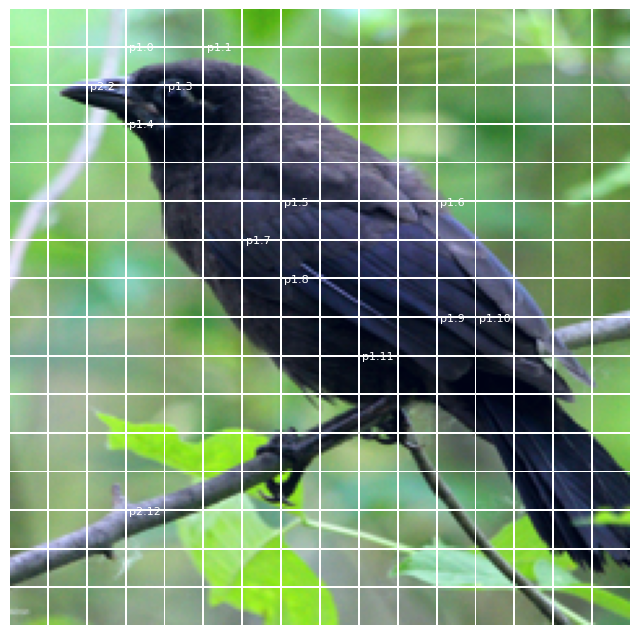

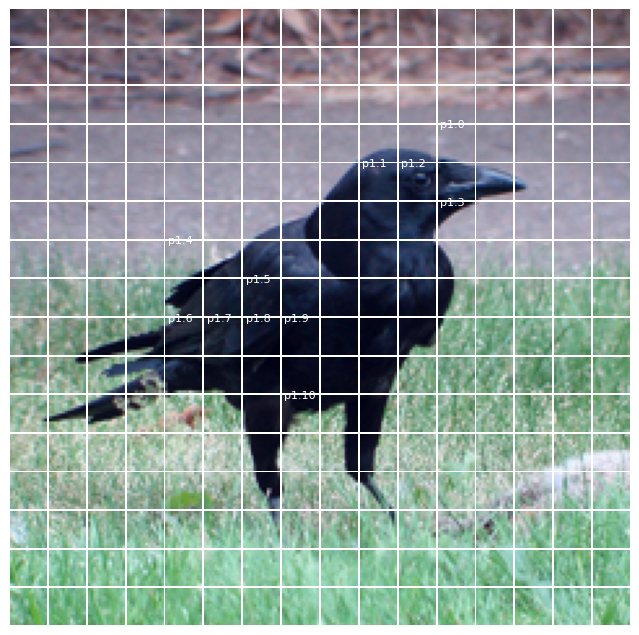

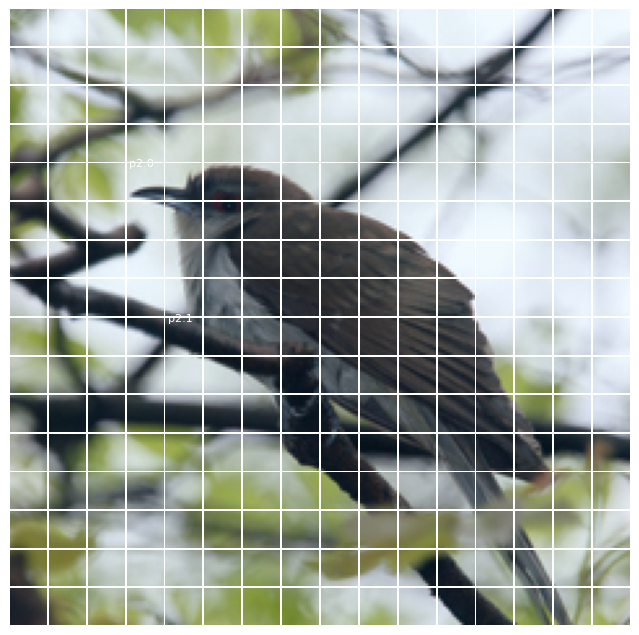

Query Patch-to-Token Mapping:
Query Patch 19: p1.0
Query Patch 21: p1.1
Query Patch 34: p2.2
Query Patch 36: p1.3
Query Patch 51: p1.4
Query Patch 87: p1.5
Query Patch 91: p1.6
Query Patch 102: p1.7
Query Patch 119: p1.8
Query Patch 139: p1.9
Query Patch 140: p1.10
Query Patch 153: p1.11
Query Patch 211: p2.12

Prototype 1 Patch-to-Token Mapping:
Prototype Patch 59: p1.0
Prototype Patch 73: p1.1
Prototype Patch 74: p1.2
Prototype Patch 91: p1.3
Prototype Patch 100: p1.4
Prototype Patch 118: p1.5
Prototype Patch 132: p1.6
Prototype Patch 133: p1.7
Prototype Patch 134: p1.8
Prototype Patch 135: p1.9
Prototype Patch 167: p1.10

Prototype 2 Patch-to-Token Mapping:
Prototype Patch 67: p2.0
Prototype Patch 132: p2.1


In [128]:
# Initialize the dictionaries to store the mappings
query_patch_to_token = []  # List for query patches
prototype_patch_to_token = [[] for _ in range(2)]  # Lists for prototypes (currently 2 prototypes)

for counter, img in enumerate(inputs):
    # Permute the image to HWC format for easier visualization
    img = img.permute(1, 2, 0)

    H, W, C = img.shape

    dummy_input = torch.zeros(1, C, H, W, device='cuda')
    outputs = model(dummy_input)

    NUMBER_OF_PATCHES, _ = outputs.last_hidden_state[0, 1:, :].shape
    NUMBER_OF_PATCHES_H = NUMBER_OF_PATCHES_W = int(np.sqrt(NUMBER_OF_PATCHES))
    PATCH_SIZE = model.config.patch_size

    patch_width = PATCH_SIZE
    n_rows = H // patch_width
    n_cols = W // patch_width

    cropped_img = img[:n_rows * patch_width, :n_cols * patch_width, :]

    # Into patches [n_rows, n_cols, patch_width, patch_width, C]
    patches = torch.empty(n_rows, n_cols, patch_width, patch_width, C)
    for chan in range(C):
        patches[..., chan] = (
            cropped_img[..., chan]
            .reshape(n_rows, patch_width, n_cols, patch_width)
            .permute(0, 2, 1, 3)
        )

    # Initialize counters for query and prototypes
    query_patch_order = 0
    prototype_patch_order = [0, 0]  # One for each prototype image

    # Plot the patches
    f, axs = plt.subplots(n_rows, n_cols, figsize=(8, 8))
    best_buddy_counter = 0

    for row_idx in range(n_rows):
        for col_idx in range(n_cols):
            # Current patch index
            patch_index = row_idx * n_cols + col_idx

            # Plot the patch
            axs[row_idx, col_idx].imshow(imsc(patches[row_idx, col_idx, ...].permute(2, 0, 1), lim=[img.min(), img.max()]))
            axs[row_idx, col_idx].axis('off')

            if counter == 0:  # Query image
                if patch_index in query_indices_to_show:
                    if best_buddies_prototypes_indices[best_buddy_counter] > NUMBER_OF_PATCHES:  # Corresponds to Prototype 2
                        token = f"p2.{query_patch_order}"
                        query_patch_order += 1
                    else:  # Corresponds to Prototype 1
                        token = f"p1.{query_patch_order}"
                        query_patch_order += 1

                    # Store in the query list
                    query_patch_to_token.append((patch_index, token))

                    # Add token as text on the patch
                    axs[row_idx, col_idx].text(0.4, 0.5, token, fontsize=8, color='white')

                    best_buddy_counter += 1

            elif counter == 1:  # Prototype 1
                if patch_index in prototype_indices_to_show:
                    token = f"p1.{prototype_patch_order[0]}"
                    prototype_patch_order[0] += 1

                    # Store in the first prototype list
                    prototype_patch_to_token[0].append((patch_index, token))

                    # Add token as text on the patch
                    axs[row_idx, col_idx].text(0.4, 0.5, token, fontsize=8, color='white')

                    best_buddy_counter += 1

            elif counter == 2:  # Prototype 2
                if patch_index + NUMBER_OF_PATCHES in prototype_indices_to_show:
                    token = f"p2.{prototype_patch_order[1]}"
                    prototype_patch_order[1] += 1

                    # Store in the second prototype list
                    prototype_patch_to_token[1].append((patch_index, token))

                    # Add token as text on the patch
                    axs[row_idx, col_idx].text(0.4, 0.5, token, fontsize=8, color='white')

                    best_buddy_counter += 1

    # Final formatting for the plot
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    f.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

# Print the mappings
print("Query Patch-to-Token Mapping:")
for patch, token in query_patch_to_token:
    print(f"Query Patch {patch}: {token}")

for i, prototype_mapping in enumerate(prototype_patch_to_token):
    print(f"\nPrototype {i + 1} Patch-to-Token Mapping:")
    for patch, token in prototype_mapping:
        print(f"Prototype Patch {patch}: {token}")


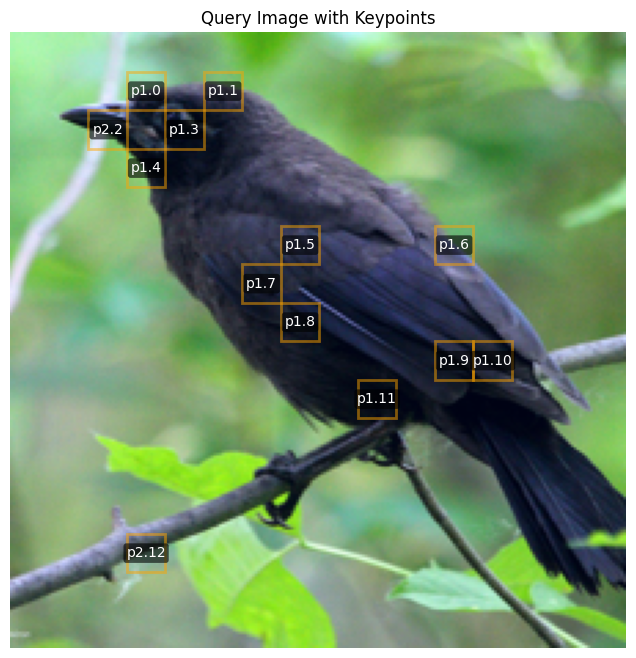

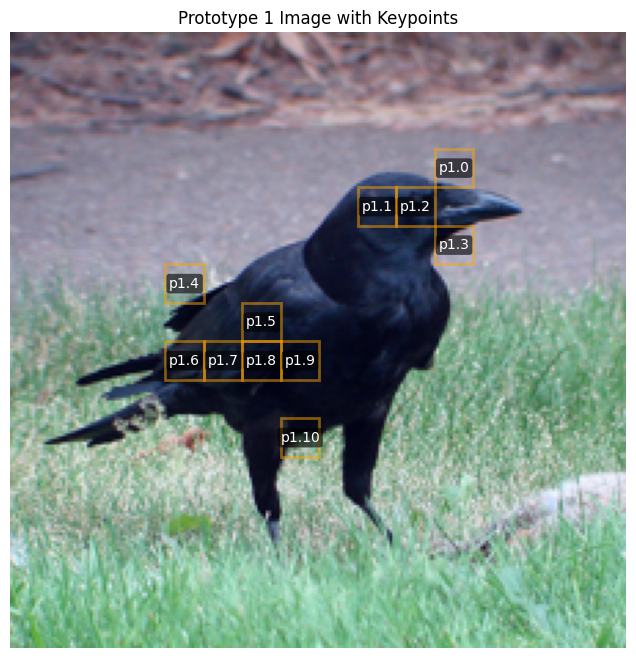

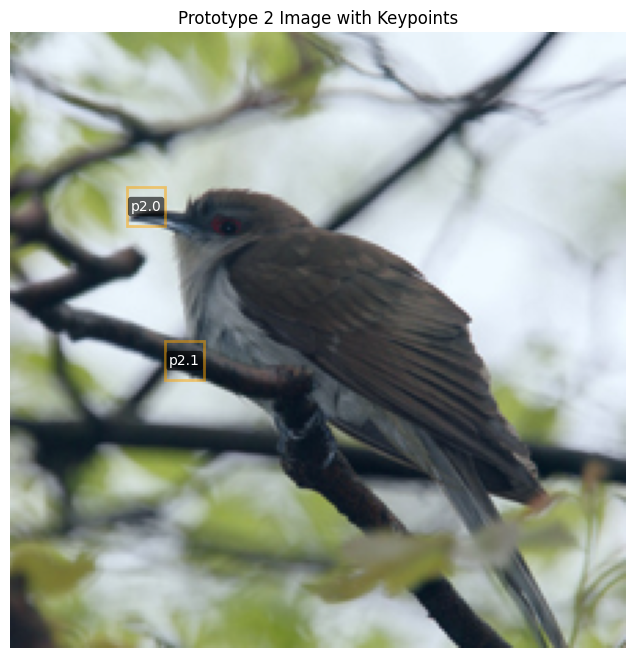

In [129]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Function to overlay keypoints with patches on the full image
def draw_keypoints_on_image_with_mapping(image, patch_to_token_mapping, PATCH_SIZE, title="Image with Keypoints"):
    """
    Draw keypoints corresponding to patches overlaid on the full image.
    
    Parameters:
        image: The full image as a tensor or numpy array (HWC format).
        patch_to_token_mapping: A list of (patch_index, token) mappings.
        PATCH_SIZE: Size of each patch (assumes square patches).
        title: Title of the visualization.
    """
    # Convert the image tensor to numpy if necessary
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    if image.shape[0] == 3:  # Convert CHW to HWC
        image = image.transpose(1, 2, 0)
    
    # Ensure image is in the valid range [0, 1]
    image = (image - image.min()) / (image.max() - image.min())

    # Create a matplotlib figure
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(image)
    ax.set_title(title)
    ax.axis('off')

    # Overlay each keypoint
    for patch_index, token in patch_to_token_mapping:
        # Convert patch index to (row, col) in the grid
        num_cols = image.shape[1] // PATCH_SIZE
        row = patch_index // num_cols
        col = patch_index % num_cols

        # Compute the coordinates of the patch center
        x = col * PATCH_SIZE + PATCH_SIZE // 2
        y = row * PATCH_SIZE + PATCH_SIZE // 2

        # Draw a rectangle for the patch
        rect = Rectangle((col * PATCH_SIZE, row * PATCH_SIZE), PATCH_SIZE, PATCH_SIZE,
                         linewidth=2, edgecolor='orange', facecolor='none', alpha=0.5)
        ax.add_patch(rect)

        # Add text (token) at the patch center
        ax.text(x, y, token, color="white", fontsize=10, ha='center', va='center',
                bbox=dict(facecolor='black', edgecolor='none', alpha=0.6, boxstyle='round,pad=0.2'))

    plt.show()


# Draw keypoints for the query image
query_image = inputs[0].permute(1, 2, 0)  # Query image in HWC format
draw_keypoints_on_image_with_mapping(query_image, query_patch_to_token, PATCH_SIZE, title="Query Image with Keypoints")

# Draw keypoints for the first prototype image
prototype1_image = inputs[1].permute(1, 2, 0)  # Prototype 1 image in HWC format
draw_keypoints_on_image_with_mapping(prototype1_image, prototype_patch_to_token[0], PATCH_SIZE, title="Prototype 1 Image with Keypoints")

# Draw keypoints for the second prototype image
if len(prototype_patch_to_token) > 1:  # Ensure there is a second prototype
    prototype2_image = inputs[2].permute(1, 2, 0)  # Prototype 2 image in HWC format
    draw_keypoints_on_image_with_mapping(prototype2_image, prototype_patch_to_token[1], PATCH_SIZE, title="Prototype 2 Image with Keypoints")


In [130]:
from transformers import CLIPVisionModelWithProjection, AutoProcessor

# Load the CLIP vision model with projection and processor
model_with_projection = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-large-patch14").to('cuda')
processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")

def get_hidden_states(image, model, processor):
    """
    Process the input image to extract hidden states and projected patches.

    Parameters:
        image (torch.Tensor): Input image tensor (CHW format).
        model: CLIPVisionModelWithProjection instance.
        processor: AutoProcessor instance.

    Returns:
        hidden_states: Hidden states from the last layer.
        projected_patches: Projected patches for the image.
    """
    # Check if input is already a tensor

    if isinstance(image, torch.Tensor):
        # Convert CHW to HWC for processor compatibility
        image = image.permute(1, 2, 0).numpy()
        image = (image - image.min()) / (image.max() - image.min())
    else:
        raise TypeError(f"Expected a tensor as input, got {type(image)} instead.")

    # Process the image
    processed_inputs = processor(images=image, return_tensors="pt").to('cuda')

    # Get model outputs
    outputs = model(**processed_inputs, output_hidden_states=True)

    # Extract hidden states and projected patches
    hidden_states_in_last_layer = outputs.hidden_states[-1]
    projected_patches = model.visual_projection(hidden_states_in_last_layer[0])

    return hidden_states_in_last_layer, projected_patches


# Extract hidden states for query and prototype images
query_image = inputs[0]
prototype1_image = inputs[1]
prototype2_image = inputs[2]

query_hidden_states, query_projected_patches = get_hidden_states(query_image, model_with_projection, processor)
prototype1_hidden_states, prototype1_projected_patches = get_hidden_states(prototype1_image, model_with_projection, processor)
prototype2_hidden_states, prototype2_projected_patches = get_hidden_states(prototype2_image, model_with_projection, processor)

# Print shapes to verify
print("Query Hidden States Shape:", query_hidden_states.shape)
print("Query Projected Patches Shape:", query_projected_patches.shape)
print("Prototype 1 Hidden States Shape:", prototype1_hidden_states.shape)
print("Prototype 1 Projected Patches Shape:", prototype1_projected_patches.shape)
print("Prototype 2 Hidden States Shape:", prototype2_hidden_states.shape)
print("Prototype 2 Projected Patches Shape:", prototype2_projected_patches.shape)


Query Hidden States Shape: torch.Size([1, 257, 1024])
Query Projected Patches Shape: torch.Size([257, 768])
Prototype 1 Hidden States Shape: torch.Size([1, 257, 1024])
Prototype 1 Projected Patches Shape: torch.Size([257, 768])
Prototype 2 Hidden States Shape: torch.Size([1, 257, 1024])
Prototype 2 Projected Patches Shape: torch.Size([257, 768])


In [165]:
from transformers import AutoProcessor, CLIPVisionModelWithProjection

v_model = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-large-patch14")
v_processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")

query_image = inputs[0]
prototype1_image = inputs[1]
prototype2_image = inputs[2]

if isinstance(query_image, torch.Tensor):
    query_image = query_image.permute(1, 2, 0).cpu().numpy()  # Convert CHW to HWC for PIL compatibility
    query_image = (query_image * 255).astype('uint8')  # Scale to 0-255 and convert to uint8
    query_image = Image.fromarray(query_image)
    
if isinstance(prototype1_image, torch.Tensor):
    prototype1_image = prototype1_image.permute(1, 2, 0).cpu().numpy()  # Convert CHW to HWC for PIL compatibility
    prototype1_image = (prototype1_image * 255).astype('uint8')  # Scale to 0-255 and convert to uint8
    prototype1_image = Image.fromarray(prototype1_image)
    
if isinstance(prototype2_image, torch.Tensor):
    prototype2_image = prototype2_image.permute(1, 2, 0).cpu().numpy()  # Convert CHW to HWC for PIL compatibility
    prototype2_image = (prototype2_image* 255).astype('uint8')  # Scale to 0-255 and convert to uint8
    prototype2_image = Image.fromarray(prototype2_image)
    
img_inputs = v_processor(images=query_image, return_tensors="pt")
img_p1_inputs = v_processor(images=prototype1_image, return_tensors="pt")
img_p2_inputs = v_processor(images=prototype2_image, return_tensors="pt")

outputs_img = v_model(**img_inputs, output_hidden_states=True)
hidden_states_in_last_layer = outputs_img.hidden_states[-1]  # Last layer hidden states
query_projected_patches = v_model.visual_projection(hidden_states_in_last_layer[0])  # Visual projection

outputs_img_p1 = v_model(**img_p1_inputs, output_hidden_states=True)
p1_hidden_states_in_last_layer = outputs_img_p1.hidden_states[-1]  # Last layer hidden states
p1_projected_patches = v_model.visual_projection(p1_hidden_states_in_last_layer[0])  # Visual projection

outputs_img_p2 = v_model(**img_p2_inputs, output_hidden_states=True)
p2_hidden_states_in_last_layer = outputs_img_p2.hidden_states[-1]  # Last layer hidden states
p2_projected_patches = v_model.visual_projection(p2_hidden_states_in_last_layer[0])  # Visual projection

# Print the shapes
print(f"Hidden States Shape: {hidden_states_in_last_layer.shape}")
print(f"Projected Patches Shape: {projected_patches.shape}")
print(f"p1 Hidden States Shape: {p1_hidden_states_in_last_layer.shape}")
print(f"p1 Projected Patches Shape: {p1_projected_patches.shape}")
print(f"p1 Hidden States Shape: {p2_hidden_states_in_last_layer.shape}")
print(f"p1 Projected Patches Shape: {p2_projected_patches.shape}")

Hidden States Shape: torch.Size([1, 257, 1024])
Projected Patches Shape: torch.Size([257, 768])
p1 Hidden States Shape: torch.Size([1, 257, 1024])
p1 Projected Patches Shape: torch.Size([257, 768])
p1 Hidden States Shape: torch.Size([1, 257, 1024])
p1 Projected Patches Shape: torch.Size([257, 768])


In [132]:
from transformers import AutoTokenizer, CLIPTextModelWithProjection
t_model = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-large-patch14")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_inputs = tokenizer(["beak", "crown", "wing", "tail", "breast",
            "throat", "eye", "forehead", "nape", "belly",
            "leg", "bill", "head", "back"], padding=True, return_tensors="pt")

outputs_text = t_model(**text_inputs, output_hidden_states=True)
text_embeds = outputs_text.text_embeds
print("text_embeds device:", text_embeds.device)
print(text_embeds.shape)

text_embeds device: cpu
torch.Size([14, 768])


In [167]:
# Assume prototype1_projected_patches and prototype2_projected_patches have been defined
N1 = prototype1_projected_patches.shape[0]  # Number of patches in prototype1

# Separate indices for prototype 1 and 2
prototype1_indices = [idx for idx in best_buddies_prototypes_indices if idx < N1]
prototype2_indices = [idx - N1 for idx in best_buddies_prototypes_indices if idx >= N1]

# Debug: Print index ranges
print("Max Index for Prototype 1:", max(prototype1_indices) if prototype1_indices else "None")
print("Max Index for Prototype 2:", max(prototype2_indices) if prototype2_indices else "None")
print("Total Indices for Prototype 1:", len(prototype1_indices))
print("Total Indices for Prototype 2:", len(prototype2_indices))


Max Index for Prototype 1: 167
Max Index for Prototype 2: 131
Total Indices for Prototype 1: 11
Total Indices for Prototype 2: 2


In [174]:
# Normalize embeddings
query_projected_patches_normalized = query_projected_patches / query_projected_patches.norm(dim=1, keepdim=True)
p1_projected_patches_normalized = p1_projected_patches / p1_projected_patches.norm(dim=1, keepdim=True)
p2_projected_patches_normalized = p2_projected_patches / p2_projected_patches.norm(dim=1, keepdim=True)

text_embeds_normalized = text_embeds / text_embeds.norm(dim=1, keepdim=True)

# Compute distances with normalized embeddings
query_sims = torch.cdist(query_projected_patches_normalized, text_embeds_normalized, p=2)*0.35
p1_sims = torch.cdist(p1_projected_patches_normalized, text_embeds_normalized, p=2)*0.35
p2_sims = torch.cdist(p2_projected_patches_normalized, text_embeds_normalized, p=2)*0.35

#sims = torch.cdist(query_projected_patches, text_embeds, p=2)
best_buddy_similarities = query_sims[best_buddies_query_indices]
p1_best_buddy_similarities = p1_sims[prototype1_indices]
p2_best_buddy_similarities = p2_sims[prototype2_indices]

print(f"Best Buddies Query Indices: {best_buddies_query_indices}")
print(f"Best Buddy Similarities (Shape: {best_buddy_similarities.shape}):\n{best_buddy_similarities}")
max_values, max_indices = best_buddy_similarities.max(dim=1)
print(f"Max Values (Shape: {max_values.shape}):\n{max_values}")
print(f"Max Indices (Shape: {max_indices.shape}):\n{max_indices}")

# Find the max similarity values and corresponding text indices for prototype 1
p1_max_values, p1_max_indices = p1_best_buddy_similarities.min(dim=1)
print(f"Best Buddies prototype1 Indices: {prototype1_indices}")
print(f"\nPrototype 1 Best Buddy Similarities (Shape: {p1_best_buddy_similarities.shape}):\n{p1_best_buddy_similarities}")
print(f"Prototype 1 Max Values (Shape: {p1_max_values.shape}):\n{p1_max_values}")
print(f"Prototype 1 Max Indices (Shape: {p1_max_indices.shape}):\n{p1_max_indices}")

# Find the max similarity values and corresponding text indices for prototype 2
print(f"Best Buddies prototype2 Indices: {prototype2_indices}")
p2_max_values, p2_max_indices = p2_best_buddy_similarities.min(dim=1)
print(f"\nPrototype 2 Best Buddy Similarities (Shape: {p2_best_buddy_similarities.shape}):\n{p2_best_buddy_similarities}")
print(f"Prototype 2 Max Values (Shape: {p2_max_values.shape}):\n{p2_max_values}")
print(f"Prototype 2 Max Indices (Shape: {p2_max_indices.shape}):\n{p2_max_indices}")


Best Buddies Query Indices: [ 19  21  34  36  51  87  91 102 119 139 140 153 211]
Best Buddy Similarities (Shape: torch.Size([13, 14])):
tensor([[0.4923, 0.5006, 0.4857, 0.5035, 0.4965, 0.5120, 0.4929, 0.4967, 0.4958,
         0.5042, 0.4964, 0.4926, 0.5039, 0.4942],
        [0.4823, 0.4942, 0.4814, 0.4931, 0.4882, 0.4907, 0.4868, 0.4973, 0.4922,
         0.4967, 0.4798, 0.4919, 0.4918, 0.4920],
        [0.4942, 0.4828, 0.4697, 0.4773, 0.4781, 0.4987, 0.4849, 0.4780, 0.4734,
         0.4871, 0.4794, 0.4813, 0.4880, 0.4680],
        [0.4776, 0.4830, 0.4672, 0.4742, 0.4755, 0.4952, 0.4761, 0.4776, 0.4740,
         0.4841, 0.4760, 0.4780, 0.4800, 0.4676],
        [0.4768, 0.4918, 0.4830, 0.4811, 0.4852, 0.4828, 0.4821, 0.4887, 0.4904,
         0.4846, 0.4782, 0.4840, 0.4833, 0.4821],
        [0.5030, 0.5056, 0.4987, 0.4984, 0.5028, 0.4972, 0.5083, 0.5022, 0.5033,
         0.5093, 0.4925, 0.4976, 0.5069, 0.5060],
        [0.5136, 0.5041, 0.5189, 0.5093, 0.5115, 0.5053, 0.4985, 0.4977, 0.50

In [175]:
# Assume text_descriptions contains the list of text corresponding to the text embeddings
text_descriptions = [
    "beak", "crown", "wing", "tail", "breast",
    "throat", "eye", "forehead", "nape", "belly",
    "leg", "bill", "head", "back"
]

# Map max indices to text descriptions
max_text_descriptions = [text_descriptions[idx] for idx in max_indices.tolist()]
print(f"Text Descriptions for Best Buddies:\n{max_text_descriptions}")

# Map prototype 1 keypoints to text descriptions
p1_text_descriptions = [text_descriptions[idx] for idx in p1_max_indices.tolist()]
print(f"Prototype 1 Text Descriptions:\n{p1_text_descriptions}")

# Map prototype 2 keypoints to text descriptions
p2_text_descriptions = [text_descriptions[idx] for idx in p2_max_indices.tolist()]
print(f"Prototype 2 Text Descriptions:\n{p2_text_descriptions}")

Text Descriptions for Best Buddies:
['throat', 'forehead', 'throat', 'throat', 'crown', 'belly', 'wing', 'belly', 'belly', 'crown', 'belly', 'belly', 'nape']
Prototype 1 Text Descriptions:
['throat', 'leg', 'forehead', 'beak', 'forehead', 'leg', 'forehead', 'forehead', 'nape', 'forehead', 'beak']
Prototype 2 Text Descriptions:
['beak', 'leg']


In [176]:
# Combine all relevant information into a structured format
best_buddies_data = []

# Iterate over best buddy indices
for i, patch_idx in enumerate(best_buddies_query_indices):
    max_value = max_values[i].item()  # Similarity value
    max_text = text_descriptions[max_indices[i].item()]  # Text description
    best_buddies_data.append({
        "patch_index": patch_idx,   # Patch number
        "text_description": max_text,  # Text
        "similarity_value": max_value  # Similarity score
    })

# Print the structured data
for data in best_buddies_data:
    print(f"Patch {data['patch_index']}: '{data['text_description']}' with similarity {data['similarity_value']:.4f}")

Patch 19: 'throat' with similarity 0.5120
Patch 21: 'forehead' with similarity 0.4973
Patch 34: 'throat' with similarity 0.4987
Patch 36: 'throat' with similarity 0.4952
Patch 51: 'crown' with similarity 0.4918
Patch 87: 'belly' with similarity 0.5093
Patch 91: 'wing' with similarity 0.5189
Patch 102: 'belly' with similarity 0.5073
Patch 119: 'belly' with similarity 0.4953
Patch 139: 'crown' with similarity 0.4736
Patch 140: 'belly' with similarity 0.5054
Patch 153: 'belly' with similarity 0.5021
Patch 211: 'nape' with similarity 0.4963


In [177]:
# Combine all relevant information into a structured format for Prototype 1
prototype1_best_buddies_data = []

# Iterate over prototype 1 indices
for i, patch_idx in enumerate(prototype1_indices):
    max_value = p1_max_values[i].item()  # Similarity value
    max_text = text_descriptions[p1_max_indices[i].item()]  # Text description
    prototype1_best_buddies_data.append({
        "patch_index": patch_idx,   # Patch number
        "text_description": max_text,  # Text
        "similarity_value": max_value  # Similarity score
    })

# Print the structured data for Prototype 1
print("\nPrototype 1 Keypoints and Text Descriptions:")
for data in prototype1_best_buddies_data:
    print(f"Patch {data['patch_index']}: '{data['text_description']}' with similarity {data['similarity_value']:.4f}")



Prototype 1 Keypoints and Text Descriptions:
Patch 59: 'throat' with similarity 0.4827
Patch 73: 'leg' with similarity 0.4837
Patch 74: 'forehead' with similarity 0.4892
Patch 91: 'beak' with similarity 0.4664
Patch 133: 'forehead' with similarity 0.4698
Patch 100: 'leg' with similarity 0.4962
Patch 118: 'forehead' with similarity 0.4854
Patch 135: 'forehead' with similarity 0.4758
Patch 134: 'nape' with similarity 0.4930
Patch 132: 'forehead' with similarity 0.4825
Patch 167: 'beak' with similarity 0.4872


In [178]:
# Combine all relevant information into a structured format for Prototype 2
prototype2_best_buddies_data = []

# Iterate over prototype 2 indices
for i, patch_idx in enumerate(prototype2_indices):
    max_value = p2_max_values[i].item()  # Similarity value
    max_text = text_descriptions[p2_max_indices[i].item()]  # Text description
    prototype2_best_buddies_data.append({
        "patch_index": patch_idx,   # Patch number
        "text_description": max_text,  # Text
        "similarity_value": max_value  # Similarity score
    })

# Print the structured data for Prototype 2
print("\nPrototype 2 Keypoints and Text Descriptions:")
for data in prototype2_best_buddies_data:
    print(f"Patch {data['patch_index']}: '{data['text_description']}' with similarity {data['similarity_value']:.4f}")



Prototype 2 Keypoints and Text Descriptions:
Patch 66: 'beak' with similarity 0.4828
Patch 131: 'leg' with similarity 0.4835


C:\Users\Shon\AppData\Local\Temp\ipykernel_6112\3450937766.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")  # Use a colormap with 20 distinct colors


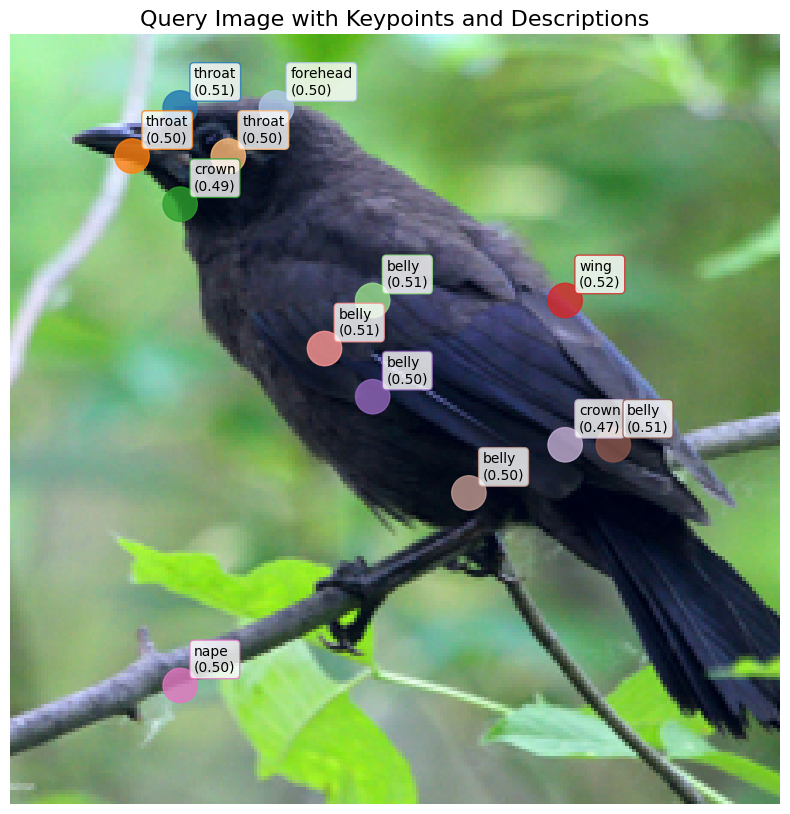

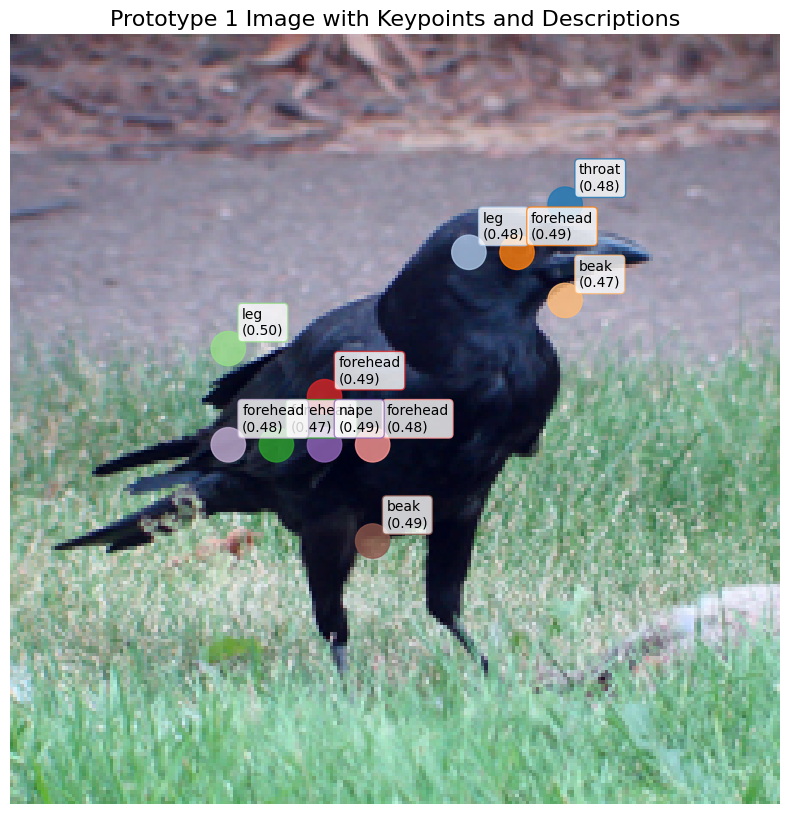

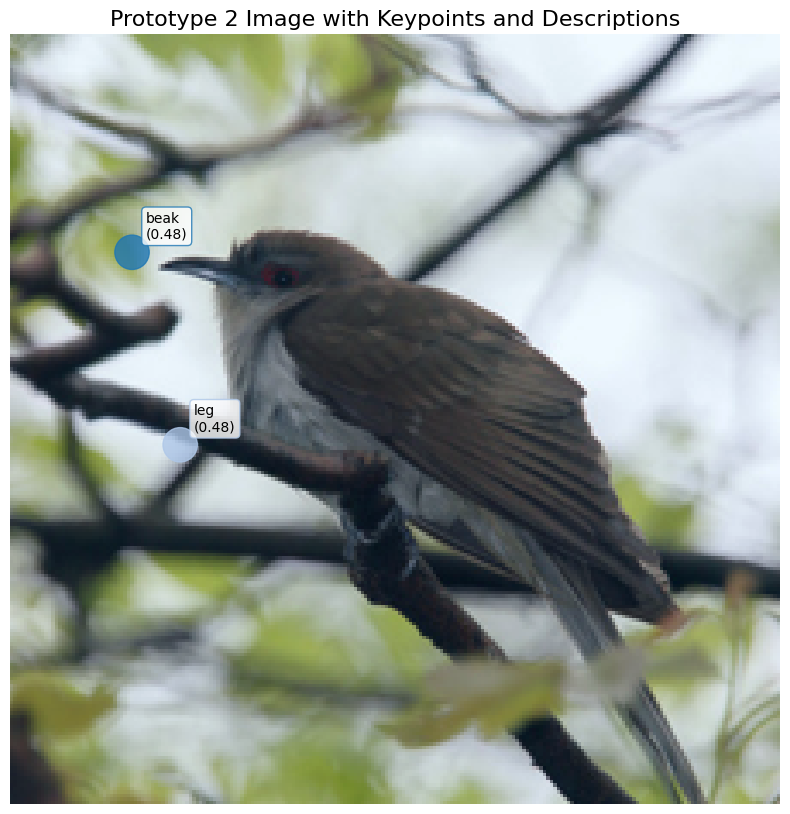

In [179]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.cm import get_cmap

def plot_keypoints_with_text_colored(image_tensor, best_buddies_data, PATCH_SIZE, title="Query Image with Keypoints"):
    """
    Plot the keypoints on the image with text descriptions, similarity values, and patch numbers.
    Different keypoints are displayed in different colors.
    
    Parameters:
        image_tensor (torch.Tensor): The query image in CHW format (e.g., inputs[0]).
        best_buddies_data (list): A list of dictionaries containing patch_index, text_description, and similarity_value.
        PATCH_SIZE (int): Size of each patch (assumes square patches).
        title (str): Title of the plot.
    """
    # Convert torch.Tensor (CHW) to numpy array (HWC) for visualization
    image = image_tensor.permute(1, 2, 0).cpu().numpy()

    # Normalize the image to [0, 1] for proper visualization
    image = (image - image.min()) / (image.max() - image.min())

    # Generate unique colors for each keypoint
    cmap = get_cmap("tab20")  # Use a colormap with 20 distinct colors
    colors = [cmap(i % 20) for i in range(len(best_buddies_data))]

    # Plot the image
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)
    ax.set_title(title, fontsize=16)
    ax.axis("off")

    # Overlay keypoints
    for i, data in enumerate(best_buddies_data):
        patch_idx = data["patch_index"]
        description = data["text_description"]
        similarity = data["similarity_value"]
        color = colors[i]
        
        # Convert patch index to (row, col) in the grid
        num_cols = image.shape[1] // PATCH_SIZE
        row = patch_idx // num_cols
        col = patch_idx % num_cols

        # Compute the center of the patch
        x = col * PATCH_SIZE + PATCH_SIZE // 2
        y = row * PATCH_SIZE + PATCH_SIZE // 2

        # Draw a circle at the patch center
        circle = Circle((x, y), radius=5, color=color, fill=True, alpha=0.8)
        ax.add_patch(circle)

        # Add text for the patch number, description, and similarity value
        text = f"{description}\n({similarity:.2f})"
        ax.annotate(
            text, (x, y), xytext=(10, 10), textcoords="offset points",
            bbox=dict(facecolor="white", alpha=0.8, edgecolor=color, boxstyle="round,pad=0.3"),
            fontsize=10, color="black"
        )

    plt.show()

# Example usage
plot_keypoints_with_text_colored(
    image_tensor=inputs[0], 
    best_buddies_data=best_buddies_data, 
    PATCH_SIZE=PATCH_SIZE, 
    title="Query Image with Keypoints and Descriptions"
)

# Example usage for Prototype 1
plot_keypoints_with_text_colored(
    image_tensor=inputs[1],  # Prototype 1 image tensor
    best_buddies_data=prototype1_best_buddies_data,  # Data for Prototype 1
    PATCH_SIZE=PATCH_SIZE, 
    title="Prototype 1 Image with Keypoints and Descriptions"
)

# Example usage for Prototype 2
plot_keypoints_with_text_colored(
    image_tensor=inputs[2],  # Prototype 2 image tensor
    best_buddies_data=prototype2_best_buddies_data,  # Data for Prototype 2
    PATCH_SIZE=PATCH_SIZE, 
    title="Prototype 2 Image with Keypoints and Descriptions"
)


In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.patches import Circle
# from matplotlib.cm import get_cmap

# def visualize_keypoints_with_matching_colors(
#     image, patch_to_token_mapping, similarity_results, PATCH_SIZE, pair_colors, title="Image with Keypoints and Descriptions"):
#     """
#     Visualize keypoints and their corresponding text descriptions on the image with matching colors for pairs.

#     Parameters:
#         image: The full image as a tensor or numpy array (HWC format).
#         patch_to_token_mapping: A list of (patch_index, token) mappings.
#         similarity_results: A dictionary containing the similarity results with descriptions and confidences.
#         PATCH_SIZE: Size of each patch (assumes square patches).
#         pair_colors: A dictionary mapping tokens to consistent colors.
#         title: Title of the visualization.
#     """
#     # Convert the image tensor to numpy if necessary
#     if isinstance(image, torch.Tensor):
#         image = image.cpu().numpy()
#     if image.shape[0] == 3:  # Convert CHW to HWC
#         image = image.transpose(1, 2, 0)
    
#     # Ensure image is in the valid range [0, 1]
#     image = (image - image.min()) / (image.max() - image.min())
    
#     # Create a matplotlib figure
#     fig, ax = plt.subplots(figsize=(8,8))
#     ax.imshow(image)
#     ax.set_title(title, fontsize=16)
#     ax.axis('off')

#     # Overlay keypoints and descriptions
#     for patch_index, token in patch_to_token_mapping:
#         if token not in similarity_results:
#             continue
        
#         # Convert patch index to (row, col) in the grid
#         num_cols = image.shape[1] // PATCH_SIZE
#         row = patch_index // num_cols
#         col = patch_index % num_cols

#         # Compute the coordinates of the patch center
#         x = col * PATCH_SIZE + PATCH_SIZE // 2
#         y = row * PATCH_SIZE + PATCH_SIZE // 2

#         # Retrieve the description, confidence, and color
#         description = similarity_results[token]["description"]
#         confidence = similarity_results[token]["confidence"]
#         color = pair_colors.get(token, "red")  # Default to red if no pair color is defined

#         # Draw a circle for the keypoint
#         circle = Circle((x, y), radius=5, color=color, fill=True, alpha=0.8)
#         ax.add_patch(circle)

#         # Add the text description
#         text = f"{description}\n({confidence:.2f})"
#         ax.annotate(text, (x, y), xytext=(10, 10), textcoords="offset points",
#                     bbox=dict(facecolor='white', alpha=0.7, edgecolor=color, boxstyle='round,pad=0.3'),
#                     fontsize=10, color="black")

#     plt.show()

# # Generate consistent colors for each token
# def generate_matching_colors(query_patch_to_token, prototype_patch_to_token_list):
#     """
#     Generate consistent colors for each token pair across query and prototypes.
    
#     Parameters:
#         query_patch_to_token: List of query patch tokens.
#         prototype_patch_to_token_list: List of prototype patch tokens (multiple prototypes).

#     Returns:
#         pair_colors: A dictionary mapping tokens to consistent colors.
#     """
#     cmap = get_cmap("tab20")
#     pair_colors = {}

#     # Collect all tokens from query and prototypes
#     all_tokens = [token for _, token in query_patch_to_token]
#     for proto_tokens in prototype_patch_to_token_list:
#         all_tokens.extend([token for _, token in proto_tokens])

#     # Assign consistent colors to unique tokens
#     unique_tokens = sorted(set(all_tokens))
#     for i, token in enumerate(unique_tokens):
#         pair_colors[token] = cmap(i % 20)  # Assign a consistent color from the colormap

#     return pair_colors

# # Generate pair colors based on query and prototypes
# pair_colors = generate_matching_colors(query_patch_to_token, prototype_patch_to_token)

# # Visualize for query image
# visualize_keypoints_with_matching_colors(
#     image=inputs[0], 
#     patch_to_token_mapping=query_patch_to_token, 
#     similarity_results=query_similarities, 
#     PATCH_SIZE=PATCH_SIZE, 
#     pair_colors=pair_colors, 
#     title="Query Image with Keypoints and Descriptions"
# )

# # Visualize for prototype 1
# visualize_keypoints_with_matching_colors(
#     image=inputs[1], 
#     patch_to_token_mapping=prototype_patch_to_token[0], 
#     similarity_results=prototype1_similarities, 
#     PATCH_SIZE=PATCH_SIZE, 
#     pair_colors=pair_colors, 
#     title="Prototype 1 Image with Keypoints and Descriptions"
# )

# # Visualize for prototype 2 (if it exists)
# if len(prototype_patch_to_token) > 1:
#     visualize_keypoints_with_matching_colors(
#         image=inputs[2], 
#         patch_to_token_mapping=prototype_patch_to_token[1], 
#         similarity_results=prototype2_similarities, 
#         PATCH_SIZE=PATCH_SIZE, 
#         pair_colors=pair_colors, 
#         title="Prototype 2 Image with Keypoints and Descriptions"
#     )
